### Ranking with Feature History (Section 6.2.2)
* Zweck: Verbesserung des Ranking Quotienten aus der Replikation anhand der Feature Hisotry Matrizen.
* Matrix: Regressionsmatrix mit Feautre History des mozilla-central Repository
* Features: Includes, Function Calls
* Modell: Support Vector Regressionsmodell

#### Setup
* Training-Set/Test-Set: Stratified sampling auf einer Matrix (2/3 : 1/3)

#### Results
Angenommen man möchte durch die Optimierung von 30 Komponenten soviele Verwundbarkeiten wie möglich beheben. Bei der Auswahl verlässt man sich auf die Vorhersage des Regressionsmodells. Das Skript teilt die Anzahl Verwundbarkeiten, die dabei tatsächlich behoben werden, durch die Anzahl, die maximal behoben werden könnten. Der Scatterplot zeigt die einzelnen Resultate für Includes und Function Calls bei 40 Experimenten. Die durchschnittlichen Werte und die Standardabweichung des Quotienten sind in der Tabelle aufgelistet.

Includes            : 40/40
Function Calls      : 40/40
+----------------+--------------+-----------------------------+
| Features       | Quotient avg | Quotient standard deviation |
+----------------+--------------+-----------------------------+
| Includes       |     0.96     |            0.014            |
| Function Calls |     0.99     |            0.009            |
+----------------+--------------+-----------------------------+


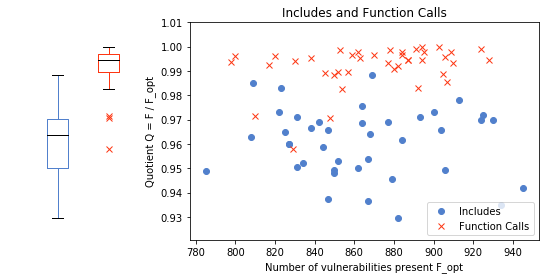

In [2]:
%matplotlib inline

from imports.matrix_helper import MatrixHelper
from imports.prediction_helper import PredictionHelper
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable

matrix_helper = MatrixHelper()
experiments_count = 40

features = [('incl', 'Includes', 'o', '#5180cc'), ('calls', 'Function Calls', 'x', '#FD3612')]
quotient_lists = {}
f_opt_lists = {}

for feature in features:
    # read pickle
    matrices = matrix_helper.load_from_parse('data/matrices/matrix_reg_{}_history.pickle'.format(feature[0]))
    quotient_lists[feature[0]] = []
    f_opt_lists[feature[0]] = []

    for i in range(experiments_count):
        print '{:20}: {:2}/{:2}\r'.format(feature[1], i+1, experiments_count),
        
        # Instantiate Prediction Helper Class and predict values for compare matrix
        prediction_helper = PredictionHelper()
        prediction_helper.calculate_validation_compare_matrix(matrices, sampling_factor=(2.0/3), model_type='SVR')

        # get the compare matrix twice:
        # Once sorted according to the PREDICTED number of vulnerabilities
        # Once sorted according to the ACTUAL number of vulnerabilities
        compare_matrix_sorted_predicted = prediction_helper.get_compare_matrix_sorted()
        compare_matrix_sorted_actual = prediction_helper.get_compare_matrix_sorted(reference_column=2)

        # Crop first 1% of both matrices
        relevant_samples_count = 30 #int(round(0.01 * len(compare_matrix_sorted_predicted)))
        compare_matrix_sorted_predicted = compare_matrix_sorted_predicted[range(relevant_samples_count)]
        compare_matrix_sorted_actual = compare_matrix_sorted_actual[range(relevant_samples_count)]

        # Sum up the actual number of vulnerabilities in both matrices
        f = sum(np.array(compare_matrix_sorted_predicted[:, 2], dtype='f'))
        f_opt = sum(np.array(compare_matrix_sorted_actual[:, 2], dtype='f'))

        f_opt_lists[feature[0]].append(f_opt)
        quotient_lists[feature[0]].append(f / f_opt)
    print

                
ymin = min([min(quotient_lists[list]) for list in quotient_lists])
ymax = max([max(quotient_lists[list]) for list in quotient_lists])

fig = plt.figure(figsize=(9, 4))

for i, feature in enumerate(features):
    ax = plt.subplot2grid((1, 10), (0, i))
    boxprops = dict(color=feature[3])
    flierprops = dict(markerfacecolor=feature[3],markeredgecolor=feature[3], marker=feature[2])
    whiskerprops = dict(color=feature[3])
    medianprops = dict(color='black')
    plt.boxplot(quotient_lists[feature[0]], flierprops=flierprops, whiskerprops=whiskerprops, boxprops=boxprops, medianprops=medianprops, widths=(0.5))
    plt.ylim(ymin=ymin/1.01, ymax=ymax*1.01)
    plt.axis('off')

ax = plt.subplot2grid((1, 10), (0, 3), colspan=7)
for feature in features:
    plt.scatter(f_opt_lists[feature[0]], quotient_lists[feature[0]], edgecolor=feature[3], linewidth='1', facecolor=feature[3], marker=feature[2], label=feature[1])

plt.xlabel('Number of vulnerabilities present F_opt')
plt.ylabel('Quotient Q = F / F_opt')
plt.ylim(ymin=ymin/1.01, ymax=ymax*1.01)
plt.legend(loc=4)
ax.set_title('Includes and Function Calls')

fig.savefig('outputs/ranking-history.pdf')
        

# print
print('==================================')
table = PrettyTable(['Features', 'Quotient avg', 'Quotient standard deviation'])
table.align["Features"] = "l"
for feature in features:
    quotient_average = '{:.2f}'.format(sum(quotient_lists[feature[0]]) / float(len(quotient_lists[feature[0]])))
    quotient_sd = '{:.3f}'.format(np.std(quotient_lists[feature[0]]))

    
    table.add_row([feature[1], quotient_average, quotient_sd])
print(table)
print('==================================')

